In [1]:
import os
import sys
import math
import random
import itertools
from sympy import *
import numpy as np
import matplotlib.pyplot as plt


import networkx as nx


from qiskit import QuantumCircuit, Aer, execute, assemble, IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info import Operator
from qiskit.circuit.library import XGate
from qiskit.visualization import plot_histogram

from qiskit_textbook.tools import array_to_latex

In [2]:
path = os.getcwd()
print(path)

/home/rkrd/Documents/Python/Quantum Lab Codes


A generating set $\Omega\subset\mathbb{Z}_2^n$ is a set that generates $\mathbb{Z}_2^n$. So, the generating set is of size at least $n$. Clearly, size can not be greater than $2^n-1$.

In [3]:
print('Enter the dimension of the Cubelike graph.')
n = int(input())
print('Minimum degree allowed: ',n,'\nMaximum degree allowed: ',2**n-1)

while True:
    print('Enter the size of the generating set.')
    d = int(input())
    if d<n or d>2**n-1:
        if d<n:
            print('The size is too small for the graph to be connected')
        elif d>2**n-1:
            print('The size is too high for the graph to be constructed')
        print('Do you want to enter the size of the generating set again?')
        option = input()
        if option == 'y' or option == 'Y':
            continue
        else:
            raise Exception('Integers below n and above 2^n not allowed')
    else:
        break        

Enter the dimension of the Cubelike graph.
3
Minimum degree allowed:  3 
Maximum degree allowed:  7
Enter the size of the generating set.
3


In [4]:
N = 2**n ### number of vertices in the graph
m = math.ceil(math.log(d,2)) ### number of qubits required
Vertex_set = [v for v in range(N)]
Gen_set = [2**i for i in range(n)]  ###at least n linearly independent sets required to generate the group
print('Vertex set: ', Vertex_set, '\nInitialized Generating set: ',Gen_set)

Vertex set:  [0, 1, 2, 3, 4, 5, 6, 7] 
Initialized Generating set:  [1, 2, 4]


In [5]:
if n<d:
    if d == 2*n-1:
        print('Do you want to generate Augment cube')
        option = input()
        if option == 'y' or option == 'Y':
            for x in range(1,n):
                vertex = 1
                for y in range(1,x+1):
                    vertex = vertex^(2**y)
                Gen_set += [vertex]
        else:
            print('Do you want to enter the remaining elements in the generating set')
            option = input()
            if option == 'y' or option == 'Y':
                print('Please enter the remaining integers (>0 and <=',N-1,').')
                Gen_set += [int(input()) for count in range(d-n)]
            else:
                Remained_vertex = list(set(Vertex_set) - set(Gen_set)) ###standard basis removed to select from rest
                Remained_vertex.remove(0)
                Add_gen_vertex = random.sample(Remained_vertex, d-n)
                Gen_set += Add_gen_vertex

    else:
        print('Do you want to enter the remaining elements in the generating set')
        option = input()
        if option == 'y' or option == 'Y':
            print('Please enter the remaining integers (>0 and <=',N-1,').')
            Gen_set += [int(input()) for count in range(d-n)]
        else:
            Remained_vertex = list(set(Vertex_set) - set(Gen_set)) ###standard basis removed to select from rest
            Remained_vertex.remove(0)
            Add_gen_vertex = random.sample(Remained_vertex, d-n)
            Gen_set += Add_gen_vertex

print('Generating set: ', [bin(x)[2:].zfill(n) for x in Gen_set])

Generating set:  ['001', '010', '100']


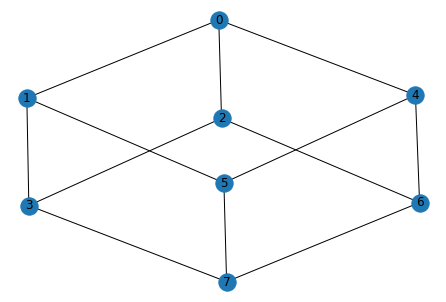

In [6]:
G = nx.Graph()
for edge in itertools.product(range(N),range(N)):
    value = edge[0]^edge[1]
    if value in Gen_set:
        G.add_edge(edge[0], edge[1])
nx.draw(G, with_labels = True)
plt.show()

Do you want to construct matrix for Grover operator (y/n)


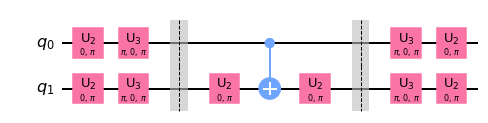

In [7]:
print('Do you want to construct matrix for Grover operator (y/n)')
ans = 'n' #input()
if ans == 'y' or ans == 'Y':
    Grover_op = (2/d)*ones(d)-eye(d)
    
    for increment in range(d, 2**m):
        Grover_op = Grover_op.col_insert(increment, Matrix([0 for i in range(increment)]))
        Grover_op = Grover_op.row_insert(increment, Matrix([[0 for i in range(increment)]+[-1]]))
    Grover = QuantumCircuit(m, name = 'Grover')
    Grover.append(Operator(np.matrix(Grover_op)),range(m))
elif m>1:
    Grover = QuantumCircuit(m, name = 'Grover')
    Grover.h(range(m))
    Grover.x(range(m))
    Grover.barrier()
    Grover.h(m-1)
    Grover.append(XGate().control(m-1),[i for i in range(m)])
    Grover.h(m-1)
    Grover.barrier()
    Grover.x(range(m))
    Grover.h(range(m))
elif m==1:
    Grover = QuantumCircuit(1, name = 'Grover')
    Grover.h(0)
    Grover.x(0)
    Grover.z(0)
    Grover.x(0)
    Grover.h(0)

Grover = Grover.decompose()
Grover.draw('mpl')

In [8]:
# print(Grover_op)

In [9]:
# backend = Aer.get_backend('unitary_simulator')
# job = execute(Grover, backend)
# result = job.result()
# unitary = result.get_unitary()
# array_to_latex(unitary)

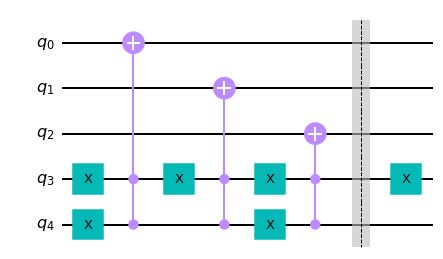

In [10]:
### we will move from 000 towards 111, instead reverse
Shift_op = QuantumCircuit(n+m, name = 'Shift')
control_qubits = [n+m-1-i for i in range(m)]
state_qubits = [n-1-i for i in range(n)]
coin_qubits = [m-1-i for i in range(m)]

balance_X = [0]*m
for i in range(d): ###Gen_set, labelling done from 0 to d-1 
    edge_label = Gen_set[i]
    target_qubits = [int(x) for x in str(bin(edge_label)[2:].zfill(n))] ###vertex qubits 
    control_X = [int(x) for x in str(bin(i)[2:].zfill(m))]  ###shifts for 1
    #print(i,'\t',edge_label,'\t',control_X,'\t',target_qubits)
    
    for x in coin_qubits:
        Shift_op.x(n+m-1-x)
        balance_X[x] = balance_X[x]^1
        #print(x,':\tbalanced X:',balance_X)
        if control_X[x] == 1:
            break
    for target in state_qubits:
        if target_qubits[target] == 1:
            Shift_op.append(XGate().control(m), control_qubits + [n-1-target])
    
Shift_op.barrier()
for balance in coin_qubits:
    if balance_X[balance] == 1:
        Shift_op.x(n+m-1-balance)

Shift_op.draw('mpl')

Enter the number of steps
6


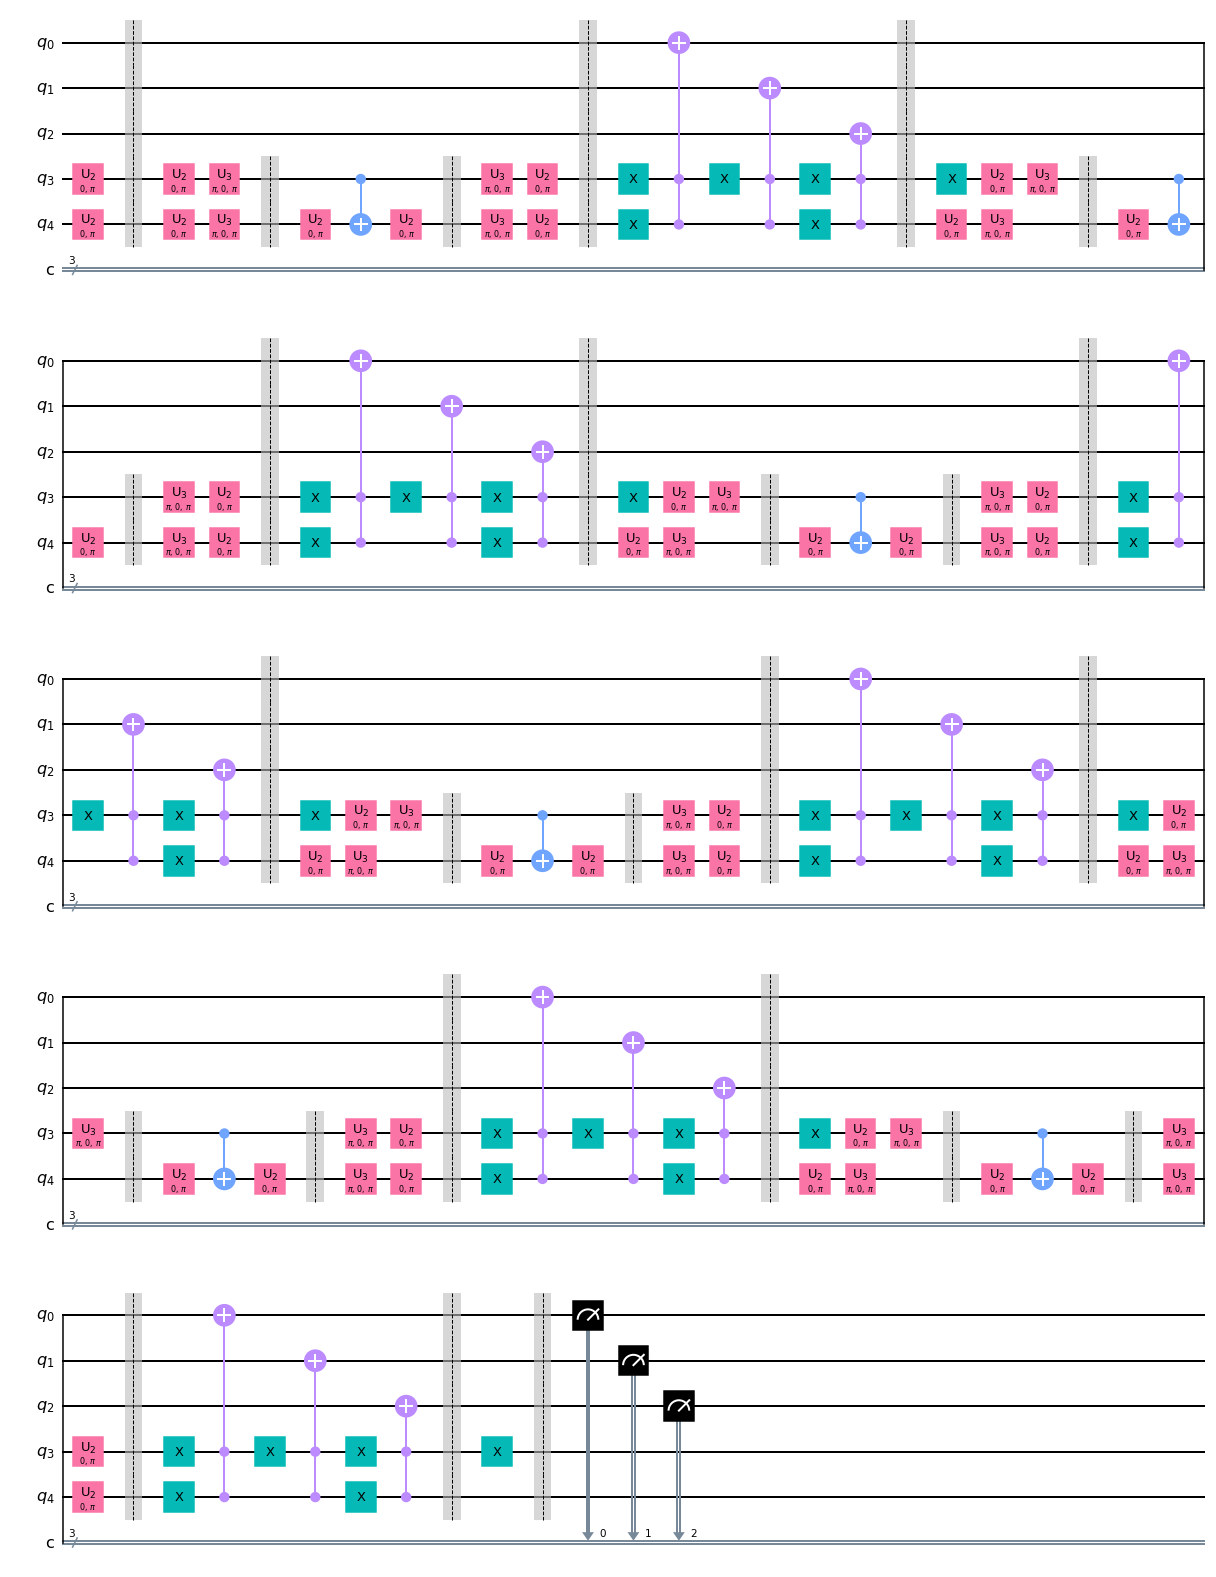

In [16]:
qc = QuantumCircuit(n+m,n)

print('Enter the number of steps')
steps = int(input())

if ans == 'y' or ans == 'Y':
    initial_vector = [1/math.sqrt(d)]*d + [0]*(2**m-d)
    qc.initialize(initial_vector, range(n,n+m))
else:
    qc.h(range(n,n+m))

qc.barrier()

for step in range(steps):
    if ans == 'y' or ans == 'Y':
        pass
    else:
        pass
    qc.append(Grover, range(n,n+m))
    qc.barrier()
    qc.append(Shift_op,range(n+m))
qc.barrier()


for i in range(n):
    qc.measure(i,i)

qc = qc.decompose()
qc.draw('mpl')


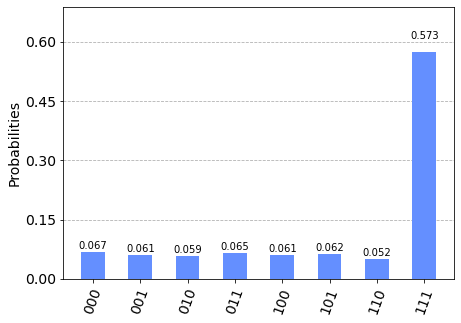

In [17]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

In [15]:
# IBMQ.load_account()
# provider = IBMQ.get_provider(hub = 'ibm-q')
# backend = provider.get_backend('ibmq_16_melbourne')

In [14]:
# job = execute(qc, backend)
# job_monitor(job)
# result = job.result()
# counts = result.get_counts()
# plot_histogram(counts)

In [15]:
# plot_histogram(counts, figsize = (30,10), title = 'step'+str(steps)).savefig('cube'+str(n)+'step'+str(steps)+'.png')
# plot_histogram(counts, figsize = (20,7), title = 'step'+str(steps)).savefig('cube'+str(n)+'step'+str(steps)+'ibm.png')

In [16]:
# print('Enter the maximum number of evolutions')
# max_step = int(input())
# print('Enter the filename')
# filename = 'Cubelike_deg_n+1' #input()
# pst_time = 0

# out_file = open(path+'/TextFiles/'+filename + '.txt','a')
# out_file.write(filename + ' graph: dim= '+str(n)+', degree= '+str(d)+'\n')
# out_file.write('Generating set: '+str(Gen_set)+'\n')

# T_p ={}
# for steps in [i for i in range(1,max_step)]:
#     qc = QuantumCircuit(n+m,n)
#     if ans == 'y' or ans == 'Y':
#         initial_vector = [1/math.sqrt(d)]*d + [0]*(2**m-d)
#         qc.initialize(initial_vector, range(n,n+m))
#     else:
#         qc.h(range(n,n+m))

#     qc.barrier()

#     for step in range(steps):
#         if ans == 'y' or ans == 'Y':
#             pass
#         else:
#             pass
#         qc.append(Grover, range(n,n+m))
#         qc.barrier()
#         qc.append(Shift_op,range(n+m))
#     qc.barrier()

    
#     for i in range(n):
#         qc.measure(i,i)
    
#     backend = Aer.get_backend('qasm_simulator')
#     job = execute(qc, backend)
#     result = job.result()
#     counts = result.get_counts()
#     zero = bin(0)[2:].zfill(n)
#     if zero in counts and counts[zero]>800:
#         print(zero,':\t',steps,': ',counts[zero]/1024)
#         out_file.write(zero+' -> T= '+str(steps)+': p= '+str(counts[zero]/1024)+'\n')
#     for x in counts:
#         if counts[x]>800 and x!=zero:
#             print(x,':\t',steps,': ',counts[x]/1024)
#             out_file.write(x+' -> T= '+str(steps)+': p= '+str(counts[x]/1024)+'\n')
#         if counts[x]>=800:
#             pst_time = steps
#             pst = counts

# out_file.write('\n\n')
# out_file.close()

Enter the maximum number of evolutions
50
Enter the filename
0000 :	 12 :  1.0
0000 :	 24 :  1.0
0000 :	 36 :  1.0
0000 :	 48 :  1.0


In [17]:
print('done with cubelike graph of dimension ',n)

done with cubelike graph of dimension  4
